In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Narma10
Non linear autoregressive moving average task: we have two time series, $X=(x_t)$ and $Y=(y_t)$. The input sequence $X$ is chosen randomly in $[0, 0.5]$.

The target ts $y$ is defined by
$$ y(t)=0.3 y(t-1) + 0.05 y(t-1) \left( \sum_{i=1}^{10} y(t-i)\right) +1.5 x(t-10)x(t-1) + 0.1$$
The goal, given the input $x(t)$, is to predict $y(t)$.

In [7]:
df = pd.read_csv('datasets/NARMA10.csv', header=None)
x = torch.Tensor(df.iloc[0,:])
y = torch.Tensor(df.iloc[1,:])

In [8]:
x =x.unsqueeze(0)
y =y.unsqueeze(0)
x.shape, y.shape

(torch.Size([1, 10000]), torch.Size([1, 10000]))

In [9]:
x_train = x[:, :4000]
x_val = x[:, 4000:5000]
x_test = x[:, 5000:]
y_train = y[:, :4000]
y_val = y[:, 4000:5000]
y_test = y[:, 5000:]


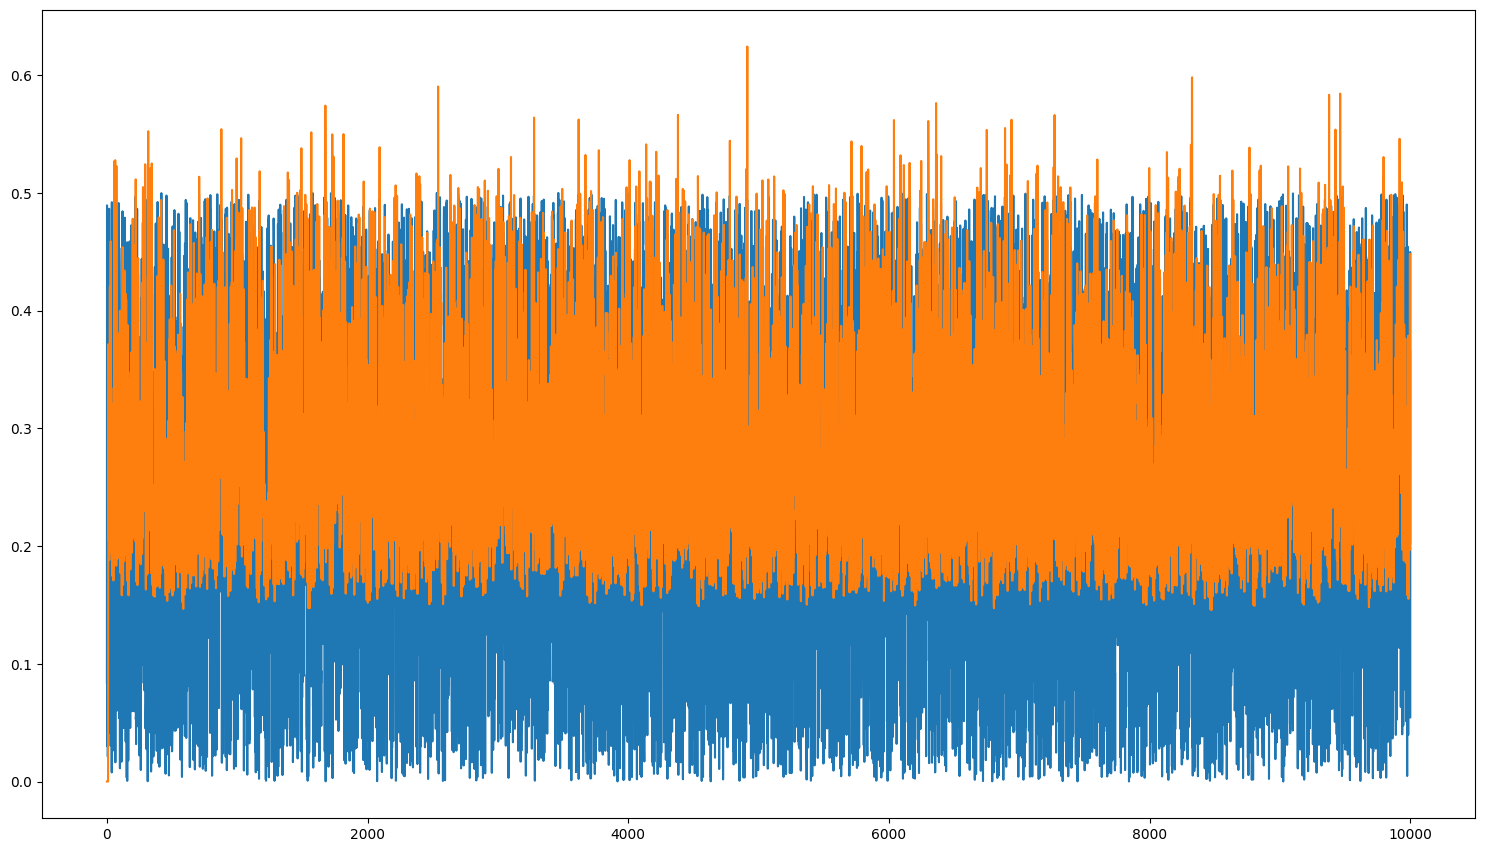

In [10]:
fig, ax = plt.subplots()

plt.plot( torch.arange(10000), x[0,:], y[0,:])
# adjust figure size
fig.set_size_inches(18.5, 10.5)
plt.show()

## TDNN
The first model is a Time Delay NN (TDNN). This type of network consist in a 1D convolution without stride, or equivalently a standard multi layer perceptron applied to a fixed size window of the input:
if $X = (x_t)_{t=1}^{T}$ is the input time series, a TDNN applies the same MLP to  $(x_{t-\tau},...,x_{t})$, where $\tau$ is the window size.

In [40]:
class TDNN(nn.Module):
    def __init__(self, window_size:int, hidden_size: int, output_size:int):
        super(TDNN, self).__init__()
        self.window_size =window_size
        self.td = nn.Linear(window_size, hidden_size)   
        self.relu=nn.ReLU()
        self.mlp = nn.Linear(hidden_size, output_size)
    
    def pad_input(self, x:torch.Tensor):
        pad_size = self.window_size - x.shape[1]
        return torch.cat(torch.zeros(1, pad_size), x)

    def forward(self, x:torch.Tensor):
        """
        just a 2 layer feedforward network applied on time windows of the input
        """
        if x.shape[1] < self.window_size:
            x= self.pad_input(x)
        h = self.relu(self.td(x))
        o = self.mlp(h)
        return o.squeeze(0)
        

In [41]:
y_val.mean()

tensor(0.2773)

In [42]:
x=torch.tensor([[1]])
x.squeeze(0).shape, x.squeeze(0)

(torch.Size([1]), tensor([1]))

In the first experiment, we feed the network the inputs $x(t- \tau),..., x(t)$, where $\tau =10$ is the window size. The window size is clearly ideal from the specifications of the problem.

In [44]:
# training loop
val_mae =0
val_loss=0
epochs =100
n_steps_update =32 #number of steps before updating the weights
train_losses_tdnn =[]
train_maes_tdnn=[]
val_losses_tdnn =[]
val_maes_tdnn=[]
tdnn = TDNN( window_size=10, hidden_size=100, output_size=1)
optimizer = torch.optim.Adam(tdnn.parameters(), lr =1e-4, weight_decay=0)
loss = torch.nn.MSELoss() 
mae = torch.nn.L1Loss()
for epoch in range(epochs):
    running_loss =0
    running_mae =0
    print(f'Epoch {epoch+1}')
    # clear outputs


    for i in range( tdnn.window_size -1, x_train.shape[1]): # from window_size to length of training data 
        x_i = x_train[:, i -tdnn.window_size +1 : i+1]
        y_hat = tdnn(x_i)
        l = loss( y_hat, y_train[:, i])
        m = mae( y_hat, y_train[:, i])
        running_loss += l
        running_mae += m
        l.backward()
        if i% n_steps_update ==0 or i == x_train.shape[1]-1:
            optimizer.step()
            optimizer.zero_grad()
    running_loss = running_loss/x_train.shape[1]
    running_mae = running_mae/x_train.shape[1]
    train_losses_tdnn.append(running_loss.detach())
    train_maes_tdnn.append(running_mae.detach())
    print(f'Training loss: {running_loss}')
    print(f'Training MAE: {running_mae}')
    print('Relative MAE: ', running_mae / y_train.abs().mean())
    # validation
    val_loss = 0
    val_mae = 0
    y_hats = torch.Tensor()
    for i in range( tdnn.window_size -1, x_val.shape[1]):
        x_i = x_val[:, i -tdnn.window_size +1 : i+1]
        with torch.no_grad():
            y_hat = tdnn(x_i)
            y_hats = torch.cat((y_hats, y_hat))
            val_loss += loss( y_hat, y_val[:, i]) 
            val_mae += mae( y_hat, y_val[:, i])
    val_loss = val_loss/x_val.shape[1]
    val_mae = val_mae/x_val.shape[1]
    val_losses_tdnn.append(val_loss.detach())
    val_maes_tdnn.append(val_mae.detach())
    print(f'Validation loss: {val_loss}')
    print(f'Validation MAE: {val_mae}')
    print('Relative MAE: ', val_mae / y_val.abs().mean())
    print('-----------------------------------')

Epoch 1
Training loss: 0.07783692330121994
Training MAE: 0.25471073389053345
Relative MAE:  tensor(0.9122, grad_fn=<DivBackward0>)
Validation loss: 0.03333069384098053
Validation MAE: 0.15441374480724335
Relative MAE:  tensor(0.5568)
-----------------------------------
Epoch 2
Training loss: 0.01809023879468441
Training MAE: 0.10311360657215118
Relative MAE:  tensor(0.3693, grad_fn=<DivBackward0>)
Validation loss: 0.009782672859728336
Validation MAE: 0.0744158923625946
Relative MAE:  tensor(0.2683)
-----------------------------------
Epoch 3
Training loss: 0.008493653498589993
Training MAE: 0.07253684848546982
Relative MAE:  tensor(0.2598, grad_fn=<DivBackward0>)
Validation loss: 0.008014674298465252
Validation MAE: 0.07137911021709442
Relative MAE:  tensor(0.2574)
-----------------------------------
Epoch 4
Training loss: 0.007615403737872839
Training MAE: 0.07072582095861435
Relative MAE:  tensor(0.2533, grad_fn=<DivBackward0>)
Validation loss: 0.007428143173456192
Validation MAE: 0.

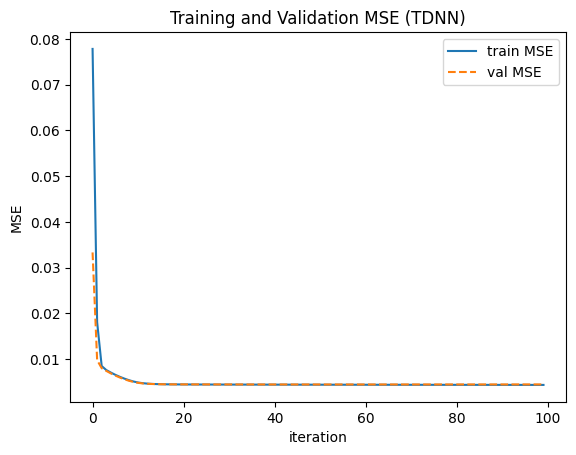

In [57]:
plt.plot(train_losses_tdnn, label='train MSE')
plt.plot(val_losses_tdnn, label='val MSE', linestyle='--')
plt.legend()
plt.title('Training and Validation MSE (TDNN)')
plt.xlabel('iteration')
plt.ylabel('MSE')
plt.show()

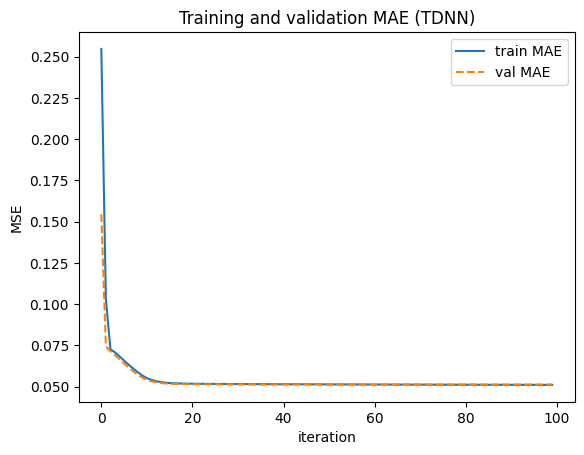

In [58]:
plt.plot(train_maes_tdnn, label ='train MAE')
plt.plot(val_maes_tdnn, label ='val MAE', linestyle='--')
plt.legend()
plt.title('Training and validation MAE (TDNN)')
plt.xlabel('iteration')
plt.ylabel('MAE')
plt.show()


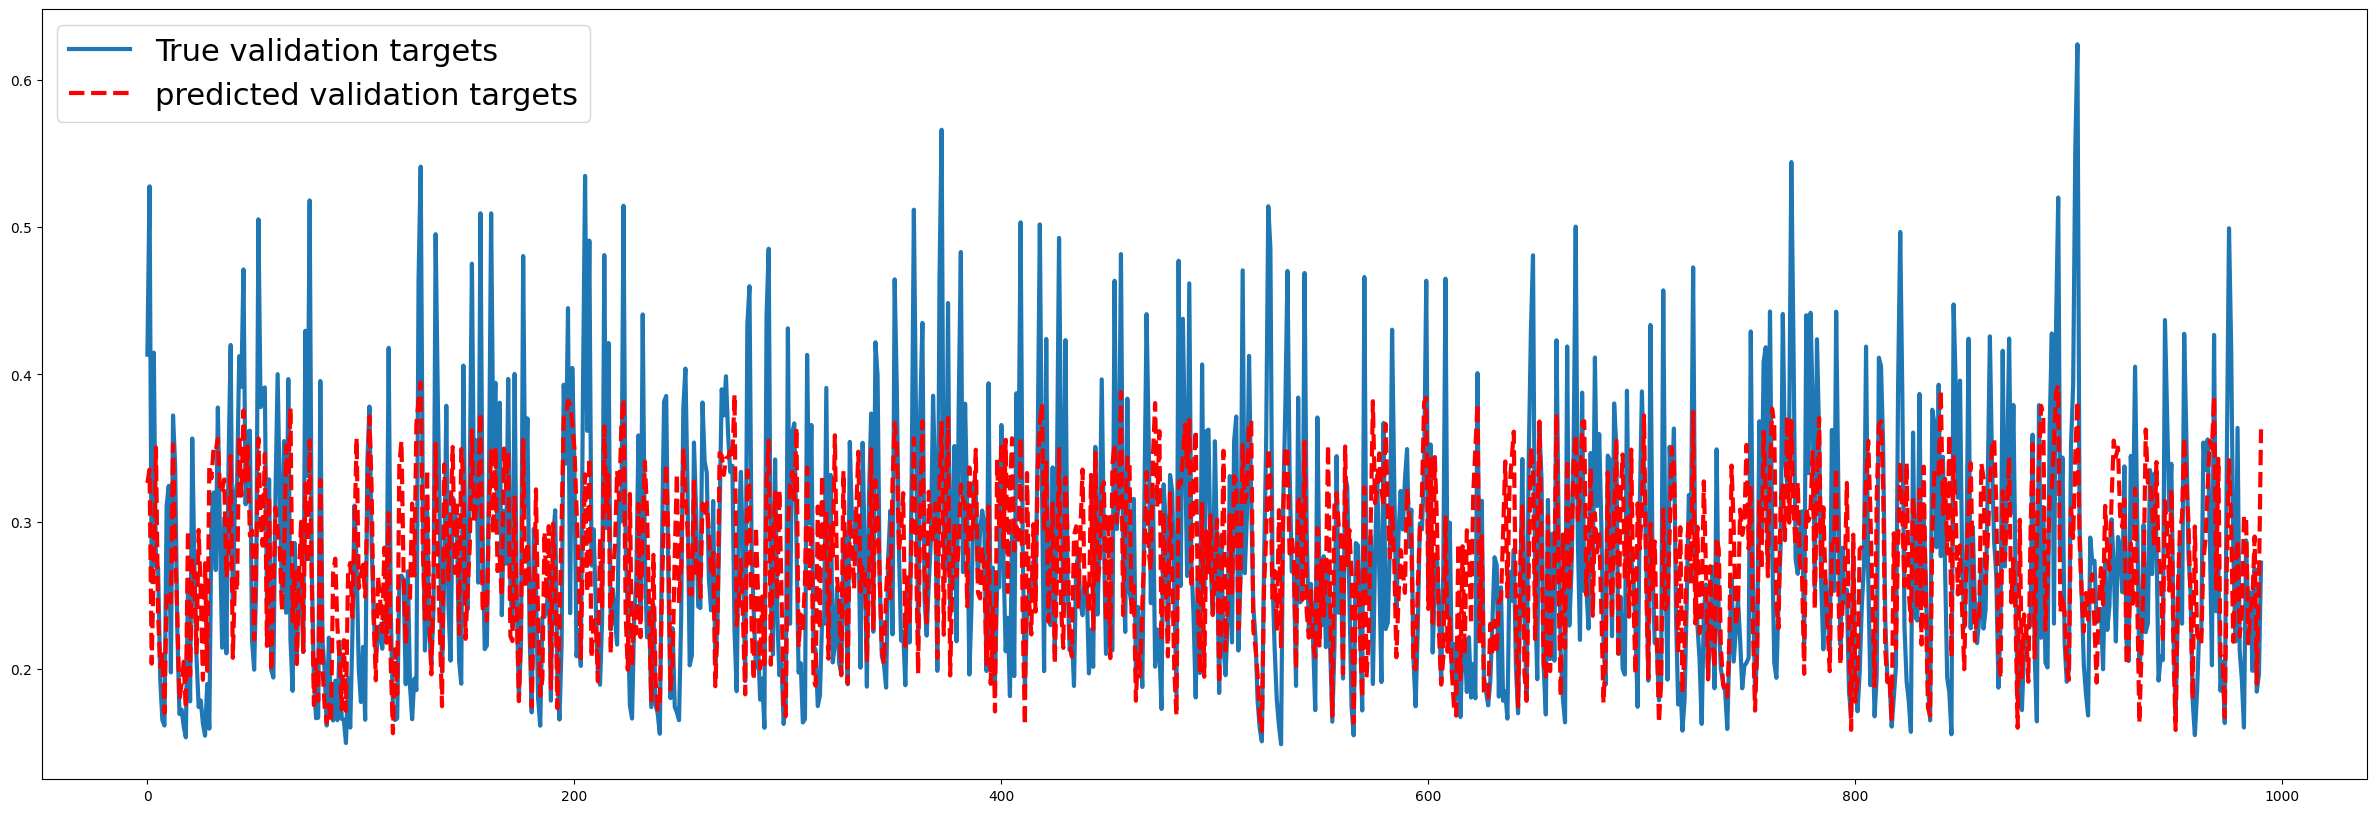

In [89]:
plt.figure(figsize=(30,10))

plt.plot(y_val[0, 9:], label ='True validation targets', linewidth=3)
plt.plot(y_hats, label ='predicted validation targets', linestyle = '--', color='r', linewidth=3)
plt.legend(fontsize=22)
plt.show()



### Discussion 
Due to the nature of the problem, the TDNN is not really able to predict correctly. For a second experiment, we pass as input to the network also the previous $y$ values.

In [92]:
tdnn_2 = TDNN( window_size=20, hidden_size=100, output_size=1)
optimizer = torch.optim.Adam(tdnn_2.parameters(), lr =1e-4, weight_decay=0)
loss = torch.nn.MSELoss()
mae = torch.nn.L1Loss()
train_losses_tdnn_2 =[]
train_maes_tdnn_2=[]
val_losses_tdnn_2 =[]
val_maes_tdnn_2=[]

for epoch in range(epochs):
    running_loss =0
    running_mae =0
    print(f'Epoch {epoch+1}')
    # clear outputs 
    for i in range( tdnn_2.window_size -1, x_train.shape[1]):
        x_i = x_train[:, i - 10 +1 : i+1]
        y_t_min_1 = y_train[:, i- 10 :i]
        input_tensor = torch.cat((x_i, y_t_min_1), dim=1)
        y_hat = tdnn_2(input_tensor)
        l = loss( y_hat, y_train[:, i])
        m = mae( y_hat, y_train[:, i])
        running_loss += l
        running_mae += m
        l.backward()
        if i% n_steps_update ==0 or i == x_train.shape[1]-1:
            optimizer.step()
            optimizer.zero_grad()
    running_loss = running_loss/x_train.shape[1]
    running_mae = running_mae/x_train.shape[1]
    train_losses_tdnn_2.append(running_loss.detach())
    train_maes_tdnn_2.append(running_mae.detach())
    print(f'Training loss: {running_loss}')
    print(f'Training MAE: {running_mae}')
    print('Relative MAE: ', running_mae / y_train.abs().mean())
    # validation
    val_loss = 0
    val_mae = 0
    y_hats = torch.Tensor()
    for i in range( tdnn_2.window_size -1, x_val.shape[1]):
        x_i = x_val[:, i - 10 +1 : i+1]
        y_t_min_1 = y_val[:, i- 10 :i]
        input_tensor = torch.cat((x_i, y_t_min_1), dim=1)
        with torch.no_grad():
            y_hat = tdnn_2(input_tensor)
            y_hats = torch.cat((y_hats, y_hat))
            val_loss += loss( y_hat, y_val[:, i]) 
            val_mae += mae( y_hat, y_val[:, i])
    val_loss = val_loss/x_val.shape[1]
    val_mae = val_mae/x_val.shape[1]
    val_losses_tdnn_2.append(val_loss.detach())
    val_maes_tdnn_2.append(val_mae.detach())
    print(f'Validation loss: {val_loss}')
    print(f'Validation MAE: {val_mae}')
    print('Relative MAE: ', val_mae / y_val.abs().mean())
    print('-----------------------------------')
    

Epoch 1
Training loss: 0.04344579949975014
Training MAE: 0.17995472252368927
Relative MAE:  tensor(0.6445, grad_fn=<DivBackward0>)
Validation loss: 0.009604053571820259
Validation MAE: 0.07343433052301407
Relative MAE:  tensor(0.2648)
-----------------------------------
Epoch 2
Training loss: 0.006160067860037088
Training MAE: 0.060304947197437286
Relative MAE:  tensor(0.2160, grad_fn=<DivBackward0>)
Validation loss: 0.005434823222458363
Validation MAE: 0.05757758393883705
Relative MAE:  tensor(0.2076)
-----------------------------------
Epoch 3
Training loss: 0.00519520090892911
Training MAE: 0.05718657746911049
Relative MAE:  tensor(0.2048, grad_fn=<DivBackward0>)
Validation loss: 0.005145952571183443
Validation MAE: 0.055930886417627335
Relative MAE:  tensor(0.2017)
-----------------------------------
Epoch 4
Training loss: 0.004906534217298031
Training MAE: 0.0554976612329483
Relative MAE:  tensor(0.1988, grad_fn=<DivBackward0>)
Validation loss: 0.004827436991035938
Validation MAE:

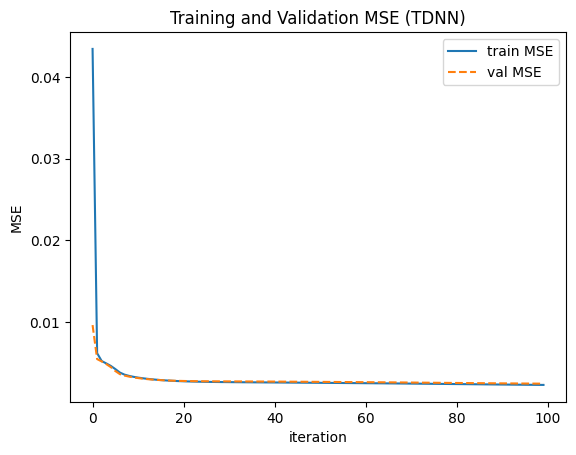

In [95]:
plt.plot(train_losses_tdnn_2, label='train MSE')
plt.plot(val_losses_tdnn_2, label='val MSE', linestyle='--')
plt.legend()
plt.title('Training and Validation MSE (TDNN)')
plt.xlabel('iteration')
plt.ylabel('MSE')
plt.show()

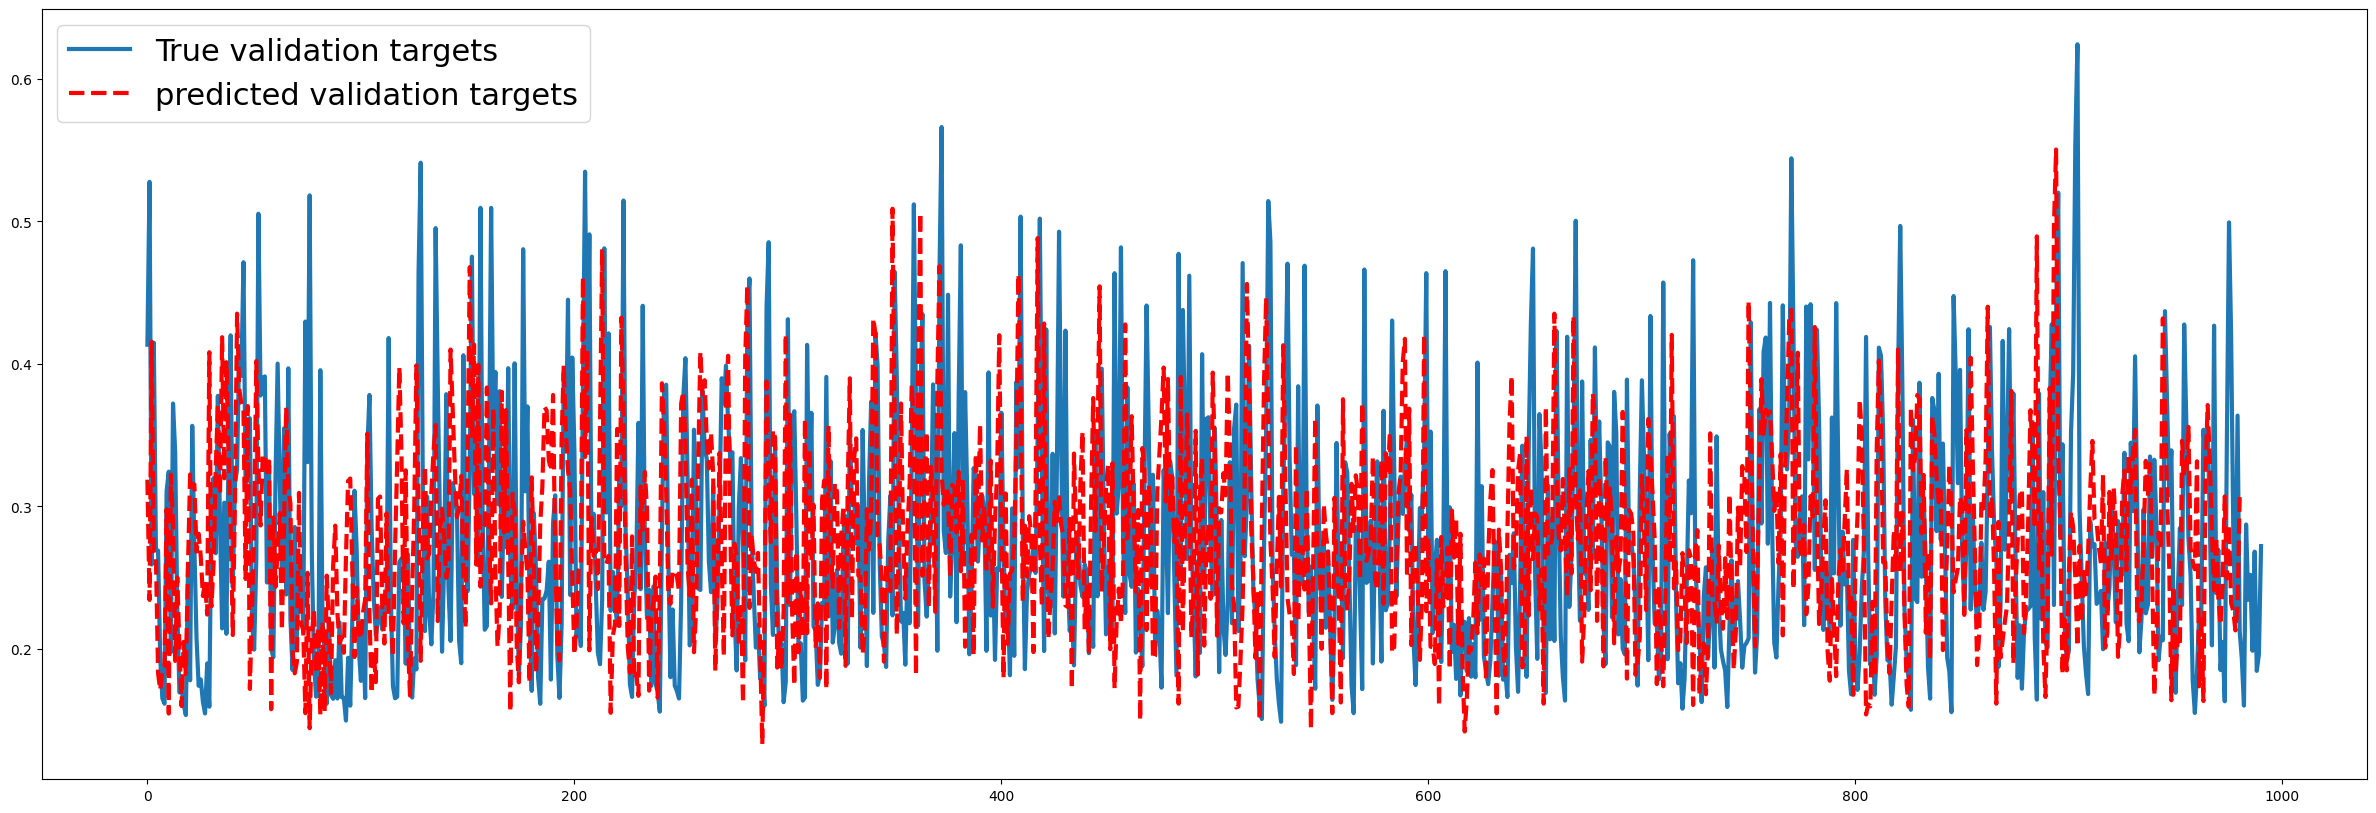

In [93]:
plt.figure(figsize=(30,10))

plt.plot(y_val[0, 9:], label ='True validation targets', linewidth=3)
plt.plot(y_hats, label ='predicted validation targets', linestyle = '--', color='r', linewidth=3)
plt.legend(fontsize=22)
plt.show()

In [67]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size) -> None:
        super().__init__()
        self.rnn =nn.RNN(input_size, hidden_size, nonlinearity ='relu')
        self.linear = nn.Linear(hidden_size, output_size)
    def forward(self, x, h_0 =None):
        outputs, h_T = self.rnn(x, h_0)
        y = self.linear(outputs)
        return y, h_T
    

In [117]:
x_train = x_train.T
x_val = x_val.T
x_test = x_test.T

y_train = y_train.T
y_val = y_val.T
y_test = y_test.T

In [122]:
model = RNN( input_size=1, hidden_size=20, output_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr =1e-3, weight_decay=1e-4)
loss = torch.nn.MSELoss()

In [123]:
val_losses =[]
val_maes =[]

In [99]:
# training loop
epochs =30
batch_size = 10
h_last= None # first hidden state
for epoch in range(epochs):
    print(f'Epoch {epoch}')
    for i in range(0, x_train.shape[0], batch_size):
        optimizer.zero_grad()
        x_batch = x_train[i:i+batch_size,:]
        y_batch = y_train[i:i+batch_size,:]
        y_hat, h_last = model(x_batch, h_last)
        h_last = h_last.detach()
        l = loss( y_hat, y_batch)
        l.backward()
        optimizer.step()


    # validation
    y_hat, _ = model(x_val, h_last)
    val_loss = loss( y_hat, y_val)
    val_mae = mae(y_hat, y_val)
    val_losses.append(val_loss)
    val_maes.append(val_mae)
    print(f'Validation loss: {val_loss}')
    print(f'MAE: {val_mae}')
    print('Relative MAE: ', val_mae / y_val.abs().mean())    

Epoch 0


c:\Users\HUAWEI\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 4000])) that is different to the input size (torch.Size([4000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: Expected hidden size (1, 1, 10), got [1, 1, 1]

In [107]:
val_losses = [v.detach() for v in val_losses]
val_maes = [v.detach() for v in val_maes]


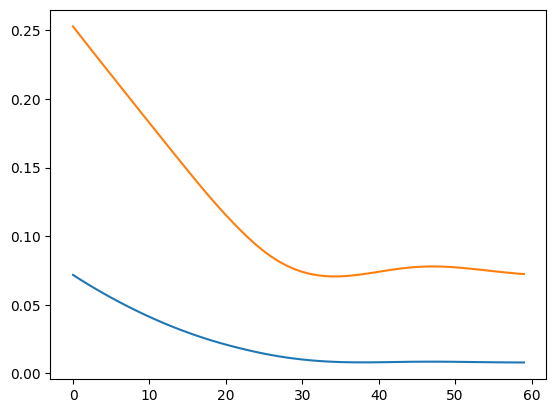

In [109]:
plt.plot(  np.arange(60), val_losses, val_maes)

In [66]:
class TransducerRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, rnn_layers=1) -> None:
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers= rnn_layers)
        self.linear = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, output_size)
    def forward(self, x, h_0 =None):
        x = x.reshape(-1, 1)
        if h_0 is not None:
            h_0 = h_0.reshape(-1, 1)
        outputs, h_T = self.rnn(x, h_0)
        
        y = self.linear(outputs)
        y = self.relu(y)
        y = self.linear2(y)
        return y, h_T
    
 

In [99]:
model = TransducerRNN(1, 10, 1, rnn_layers=1)
optimizer = torch.optim.Adam(model.parameters(), lr =1e-3, weight_decay= 1e-6)
loss = torch.nn.MSELoss()
mae =torch.nn.L1Loss()

In [100]:
train_losses_rnn =[]
val_losses_rnn=[]
val_maes_rnn=[]


In [101]:

# training loop
epochs =5000
h_last= None # first hidden state
for epoch in range(epochs):
    optimizer.zero_grad()
    running_loss =0
    # training 
    print(f'Epoch {epoch}')
    optimizer.zero_grad()
    y_hat,  h_last= model(x_train)
    l = loss( y_hat, y_train.T)
    running_loss += l
    l.backward()
    optimizer.step()
    running_loss = running_loss/x_train.shape[0]
    print(f'Training loss: {running_loss}')
    train_losses_rnn.append(running_loss.detach())


    # validation
    with torch.no_grad():
        y_hat, _ = model(x_val)
        val_loss = loss( y_hat, y_val.T)
        val_mae = mae(y_hat, y_val.T)
        val_losses_rnn.append(val_loss.detach())
        val_maes_rnn.append(val_mae.detach())
        print(f'Validation loss: {val_loss}')
        print(f'MAE: {val_mae}')
        print('Relative MAE: ', val_mae / y_val.abs().mean())    

Epoch 0
torch.Size([4000, 10])
Training loss: 0.009517845697700977
torch.Size([1000, 10])
Validation loss: 0.009123237803578377
MAE: 0.07055915892124176
Relative MAE:  tensor(0.2544)
Epoch 1
torch.Size([4000, 10])
Training loss: 0.00929431151598692
torch.Size([1000, 10])
Validation loss: 0.008927801623940468
MAE: 0.0701582208275795
Relative MAE:  tensor(0.2530)
Epoch 2
torch.Size([4000, 10])
Training loss: 0.009088430553674698
torch.Size([1000, 10])
Validation loss: 0.008749560452997684
MAE: 0.06984605640172958
Relative MAE:  tensor(0.2519)
Epoch 3
torch.Size([4000, 10])
Training loss: 0.008900045417249203
torch.Size([1000, 10])
Validation loss: 0.008588035590946674
MAE: 0.06959022581577301
Relative MAE:  tensor(0.2509)
Epoch 4
torch.Size([4000, 10])
Training loss: 0.008728615008294582
torch.Size([1000, 10])
Validation loss: 0.008442403748631477
MAE: 0.06938828527927399
Relative MAE:  tensor(0.2502)
Epoch 5
torch.Size([4000, 10])
Training loss: 0.008573460392653942
torch.Size([1000, 10

Text(0.5, 0, 'iteration')

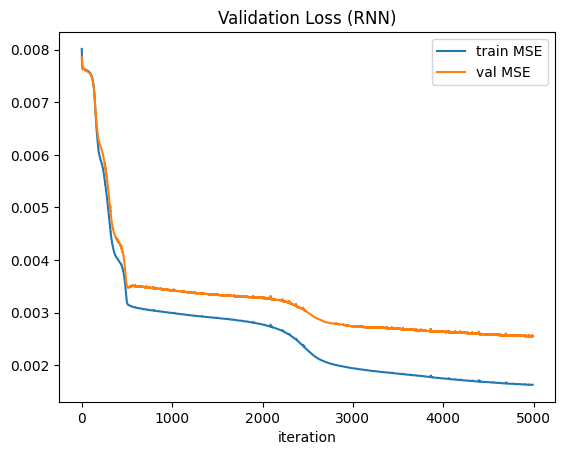

In [104]:
plt.plot((np.array(train_losses_rnn[10:])), label='train MSE')
plt.plot((np.array(val_losses_rnn[10:])), label='val MSE')
plt.legend()
plt.title('Validation Loss (RNN)')
plt.xlabel('iteration')


torch.Size([5000, 10])
torch.Size([5000, 1])
torch.Size([1000, 1])


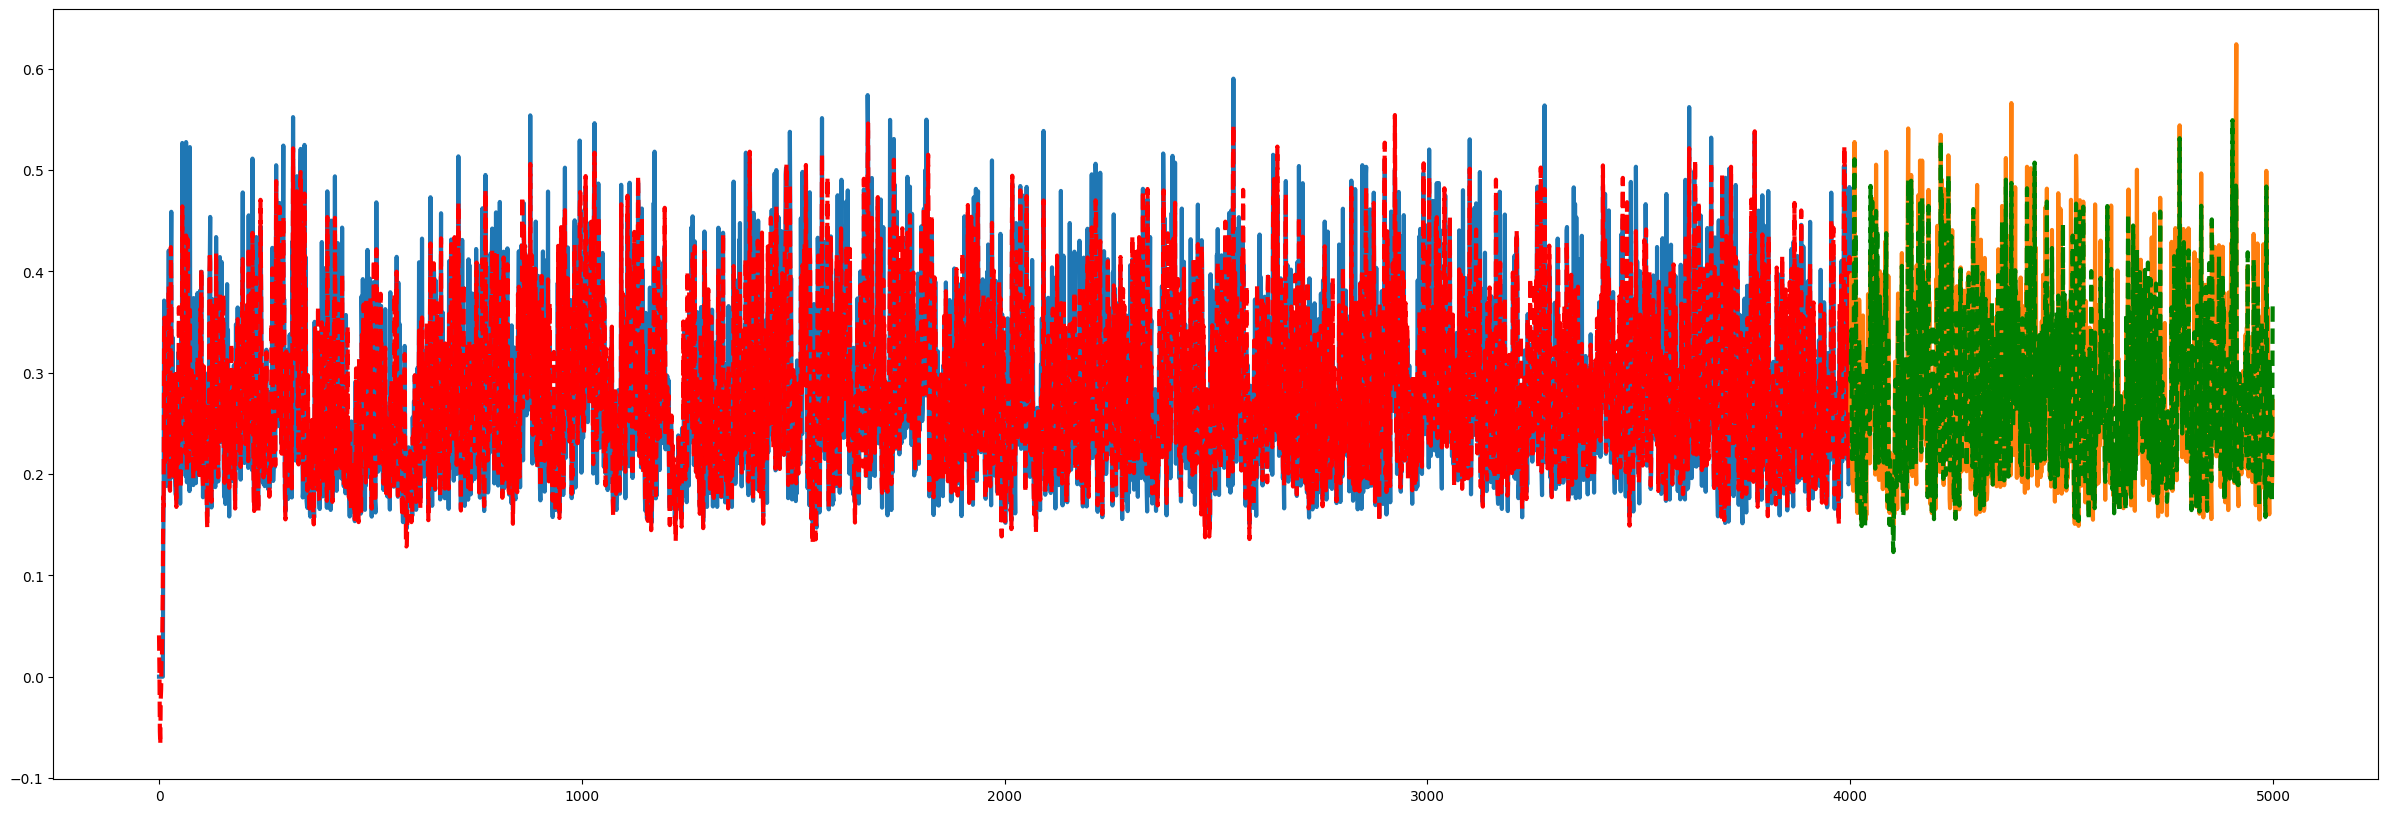

In [122]:
with torch.no_grad():
    y_hats, _ = model(torch.cat((x_train, x_val), dim=1))
    print(y_hats.shape)

y_hats_train = y_hats[ :4000,:] 
y_hats_val = y_hats[4000:5000,:]
print(y_hats_val.shape)
plt.figure(figsize=(30,10))
plt.plot(y_train.squeeze(), label ='True training targets', linewidth=3)
plt.plot(y_hats_train, label ='predicted training targets', linestyle = '--', color='r', linewidth=3)
plt.plot(np.arange(4000, 5000), y_val.squeeze(), label ='True validation targets', linewidth=3)
plt.plot(np.arange(4000, 5000), y_hats_val.squeeze(), label ='predicted validation targets', linestyle = '--', color='g', linewidth=3)


In [49]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, rnn_layers=1, activation_function ='relu') -> None:
        super().__init__()
        # define the rnn 
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.o2h = nn.Linear(output_size, hidden_size) # for the decoder
        if activation_function == 'relu':
            self.activation = nn.ReLU()
        elif activation_function == 'tanh':
            self.activation = nn.Tanh()
        else:
            raise ValueError('Activation function not supported')
        

    def forward(self, x, y, h_0 =None, p_teacher_forcing=0.5):
        outputs = []
        if h_0 is None:
            h_t = torch.zeros(1, self.hidden_size)
        else:
            h_t = h_0
        o_t = torch.zeros(self.output_size, 1) # initial output set to 0
        for i in range(x.shape[1]):
            x_t = x[:, i].reshape(1, -1)
            if torch.rand(1) < p_teacher_forcing and i !=0 : # choose whether to use the true target or the previous output
                y_t_minus_one = y[:, i-1].reshape(1, -1)
            else:
                y_t_minus_one = o_t
            
            h_t = self.activation (self.i2h(x_t) +  # input to hidden
                                    self.h2h(h_t) + # recurrence
                                    self.o2h(y_t_minus_one)) # decoder input

            o_t = self.h2o(h_t)
            outputs.append(o_t)
        return torch.cat(outputs, dim=1), h_t

In [50]:
x_train = x_train.T
x_val = x_val.T
x_test = x_test.T

y_train = y_train.T
y_val = y_val.T
y_test = y_test.T

In [52]:
rnn = DecoderRNN( input_size=1, hidden_size=20, output_size=1, activation_function='relu')

rnn(x= x_train, y=y_train)

(tensor([[-0.3747, -0.2756, -0.3019,  ..., -0.2959, -0.2957, -0.1960]],
        grad_fn=<CatBackward0>),
 tensor([[0.0000, 0.0000, 0.0000, 2.4881, 0.7831, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.3257, 1.9275, 0.0000, 0.0000, 0.0000, 1.1235, 0.9344, 0.5217,
          0.7177, 1.1388]], grad_fn=<ReluBackward0>))

In [65]:
rnn = DecoderRNN( input_size=1, hidden_size=10, output_size=1, activation_function='tanh')
optimizer = torch.optim.SGD(rnn.parameters(), lr =1e-4, nesterov=True, momentum=0.9)
loss = torch.nn.MSELoss()
mae = torch.nn.L1Loss()

val_losses_rnn=[]
val_maes_rnn=[]
epochs =1000
h_last= None # first hidden state

for epoch in range(epochs):
    optimizer.zero_grad()
    running_loss =0
    # training 
    print(f'Epoch {epoch}')
    optimizer.zero_grad()
    y_hat,  h_last= rnn(x_train, y_train)
    l = loss( y_hat, y_train)
    running_loss += l
    l.backward()
    optimizer.step()
    running_loss = running_loss/x_train.shape[0]
    print(f'Training loss: {running_loss}')


    # validation
    y_hat, _ = rnn(x_val, y_val)
    val_loss = loss( y_hat, y_val)
    val_mae = mae(y_hat, y_val)
    val_losses_rnn.append(val_loss.detach())
    val_maes_rnn.append(val_mae.detach())
    print(f'Validation loss: {val_loss}')
    print(f'MAE: {val_mae}')
    print('Relative MAE: ', val_mae / y_val.abs().mean())

Epoch 0
Training loss: 0.4349198043346405
Validation loss: 0.4300173223018646
MAE: 0.6475985050201416
Relative MAE:  tensor(2.3352, grad_fn=<DivBackward0>)
Epoch 1
Training loss: 0.43516990542411804
Validation loss: 0.43341687321662903
MAE: 0.6505609750747681
Relative MAE:  tensor(2.3459, grad_fn=<DivBackward0>)
Epoch 2
Training loss: 0.43272921442985535
Validation loss: 0.43088772892951965
MAE: 0.6485478281974792
Relative MAE:  tensor(2.3386, grad_fn=<DivBackward0>)
Epoch 3
Training loss: 0.42504817247390747
Validation loss: 0.4225541353225708
MAE: 0.6422363519668579
Relative MAE:  tensor(2.3159, grad_fn=<DivBackward0>)
Epoch 4
Training loss: 0.4217687249183655
Validation loss: 0.419877290725708
MAE: 0.6398958563804626
Relative MAE:  tensor(2.3075, grad_fn=<DivBackward0>)
Epoch 5
Training loss: 0.41568079590797424
Validation loss: 0.4113774001598358
MAE: 0.6334149837493896
Relative MAE:  tensor(2.2841, grad_fn=<DivBackward0>)
Epoch 6
Training loss: 0.4114040434360504
Validation loss: 

KeyboardInterrupt: 

In [58]:
y_hat, _ = rnn(x_val, y_val)

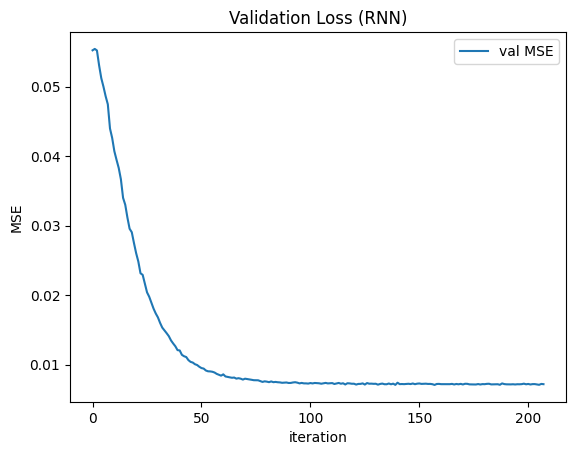

In [59]:
plt.plot(val_losses_rnn, label='val MSE')   
plt.legend()
plt.title('Validation Loss (RNN)')
plt.xlabel('iteration')
plt.ylabel('MSE')
plt.show()


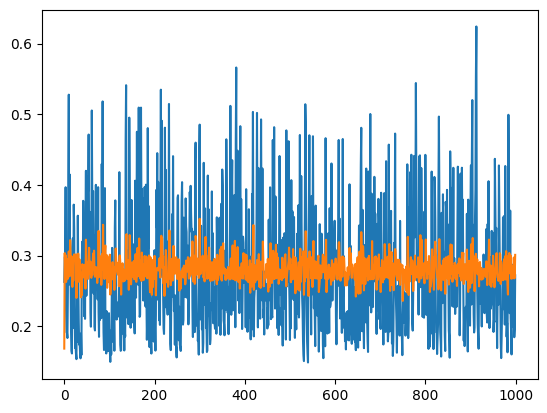

In [60]:
plt.plot(y_val.T)
plt.plot(y_hat.detach().T)